# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.00773574 -0.23112486  0.00248644  0.2876802 ] 0 1.0 False {}
state, action, reward, done, info
[ 0.00311324 -0.03603846  0.00824005 -0.00421749] 1 1.0 False {}
state, action, reward, done, info
[ 0.00239247  0.15896435  0.0081557  -0.29428924] 1 1.0 False {}
state, action, reward, done, info
[ 0.00557176 -0.03627292  0.00226991  0.00095468] 0 1.0 False {}
state, action, reward, done, info
[ 0.0048463   0.15881641  0.00228901 -0.2910112 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.00802263  0.35390565 -0.00353122 -0.58297132] 1 1.0 False {}
state, action, reward, done, info
[ 0.01510074  0.54907689 -0.01519065 -0.87676454] 1 1.0 False {}
state, action, reward, done, info
[ 0.02608228  0.74440197 -0.03272594 -1.17418424] 1 1.0 False {}
state, action, reward, done, info
[ 0.04097032  0.9399336  -0.05620962 -1.47694434] 1 1.0 False {}
state, action, reward, done, info
[ 0.05976899  1.13569521 -0.08574851 -1.78663993] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1356952123110589 -1.7866399275066926


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, next_states, actions, targetQs

In [6]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [7]:
# Q function
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits_actions = tf.layers.dense(inputs=nl2, units=action_size, trainable=False)        
        #predictions = tf.nn.softmax(logits_actions)

        # Output layer
        logits_next_states = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)        
        #predictions = tf.nn.softmax(logits_next_states)

        return logits_actions, logits_next_states

In [8]:
# This is a reward function: Rt(St+1, at) or Rt(~St+1, ~at)
def discriminator(next_states, actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # Stack/concatenate/fuse actions and states or 
        # predicted/reconstructed actions and states
        x_fused = tf.concat(values=(next_states, actions), axis=1)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [9]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, next_states, state_size, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits, next_states_logits = generator(states=states, state_size=state_size, hidden_size=hidden_size, 
                                              action_size=action_size)
    #print(actions_logits.shape, next_states_logits.shape)
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(next_states=next_states_fake, actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(next_states=next_states_real, actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [10]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [11]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)
        #print(self.states, self.next_states, self.actions, self.targetQs)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, 
            states=self.states, next_states=self.next_states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 
rewards_fake_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        rewards_fake_mean = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            # feed_dict={model.states: next_states}
            # next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)
            feed_dict = {model.states: states}
            rewards_fake = sess.run(model.rewards_fake, feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake rewards or rewarded generated actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            # print(states.shape, next_states.shape, targetQs.shape, actions.shape)
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, model.targetQs: targetQs}
            #states, next_states, actions, Qs = sess.run([model.states, model.next_states, model.actions, model.Qs], feed_dict)
            #print(states.shape, next_states.shape, actions.shape, Qs.shape)
            #rewards_real = sess.run(model.rewards_real, feed_dict)
            #d_loss = sess.run(model.d_loss, feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 2.0 Average reward fake: 0.601893961429596 Training d_loss: 1.4333 Training g_loss: 0.5260 Training q_loss: 0.4181 Explore P: 0.9998
Episode: 1 Total reward: 23.0 Average reward fake: 0.4808313250541687 Training d_loss: 1.3204 Training g_loss: 0.7339 Training q_loss: 0.4703 Explore P: 0.9975
Episode: 2 Total reward: 14.0 Average reward fake: 0.4928554594516754 Training d_loss: 1.2891 Training g_loss: 0.7103 Training q_loss: 1.0263 Explore P: 0.9961
Episode: 3 Total reward: 19.0 Average reward fake: 0.4829287528991699 Training d_loss: 1.2044 Training g_loss: 0.7336 Training q_loss: 1.8129 Explore P: 0.9943
Episode: 4 Total reward: 10.0 Average reward fake: 0.4744817614555359 Training d_loss: 1.1572 Training g_loss: 0.7570 Training q_loss: 3.0098 Explore P: 0.9933
Episode: 5 Total reward: 20.0 Average reward fake: 0.41342419385910034 Training d_loss: 1.0037 Training g_loss: 0.9003 Training q_loss: 4.4568 Explore P: 0.9913
Episode: 6 Total reward: 21.0 Average rew

Episode: 51 Total reward: 10.0 Average reward fake: 0.3098938763141632 Training d_loss: 1.1421 Training g_loss: 1.3372 Training q_loss: 6.5472 Explore P: 0.8899
Episode: 52 Total reward: 25.0 Average reward fake: 0.33245036005973816 Training d_loss: 0.6547 Training g_loss: 1.2332 Training q_loss: 17.3397 Explore P: 0.8877
Episode: 53 Total reward: 25.0 Average reward fake: 0.31262749433517456 Training d_loss: 0.8891 Training g_loss: 1.2624 Training q_loss: 105.7196 Explore P: 0.8855
Episode: 54 Total reward: 19.0 Average reward fake: 0.23942212760448456 Training d_loss: 0.5844 Training g_loss: 1.4852 Training q_loss: 172.5826 Explore P: 0.8838
Episode: 55 Total reward: 11.0 Average reward fake: 0.12409980595111847 Training d_loss: 0.3056 Training g_loss: 2.2689 Training q_loss: 141.1127 Explore P: 0.8829
Episode: 56 Total reward: 18.0 Average reward fake: 0.2136618196964264 Training d_loss: 1.2503 Training g_loss: 1.6492 Training q_loss: 116.3252 Explore P: 0.8813
Episode: 57 Total rew

Episode: 102 Total reward: 17.0 Average reward fake: 0.1401275098323822 Training d_loss: 0.4761 Training g_loss: 2.0713 Training q_loss: 20.8661 Explore P: 0.8013
Episode: 103 Total reward: 14.0 Average reward fake: 0.14692705869674683 Training d_loss: 0.5113 Training g_loss: 2.2671 Training q_loss: 126.4567 Explore P: 0.8002
Episode: 104 Total reward: 14.0 Average reward fake: 0.270624577999115 Training d_loss: 0.6624 Training g_loss: 1.6088 Training q_loss: 30.4728 Explore P: 0.7991
Episode: 105 Total reward: 9.0 Average reward fake: 0.3004811704158783 Training d_loss: 1.6369 Training g_loss: 1.2340 Training q_loss: 20.4937 Explore P: 0.7984
Episode: 106 Total reward: 32.0 Average reward fake: 0.12645165622234344 Training d_loss: 0.3026 Training g_loss: 2.3004 Training q_loss: 448.7296 Explore P: 0.7959
Episode: 107 Total reward: 25.0 Average reward fake: 0.4411896765232086 Training d_loss: 1.0199 Training g_loss: 1.2813 Training q_loss: 70.6764 Explore P: 0.7939
Episode: 108 Total r

Episode: 153 Total reward: 17.0 Average reward fake: 0.22922587394714355 Training d_loss: 0.5953 Training g_loss: 1.7102 Training q_loss: 23.2344 Explore P: 0.7328
Episode: 154 Total reward: 12.0 Average reward fake: 0.1999983787536621 Training d_loss: 0.7313 Training g_loss: 1.7128 Training q_loss: 35.3556 Explore P: 0.7319
Episode: 155 Total reward: 10.0 Average reward fake: 0.2615889310836792 Training d_loss: 0.7000 Training g_loss: 1.6655 Training q_loss: 35.2732 Explore P: 0.7312
Episode: 156 Total reward: 13.0 Average reward fake: 0.36739104986190796 Training d_loss: 0.6415 Training g_loss: 1.1768 Training q_loss: 136.7205 Explore P: 0.7303
Episode: 157 Total reward: 15.0 Average reward fake: 0.3133394420146942 Training d_loss: 0.8786 Training g_loss: 1.4089 Training q_loss: 129.6778 Explore P: 0.7292
Episode: 158 Total reward: 7.0 Average reward fake: 0.18301576375961304 Training d_loss: 0.6269 Training g_loss: 1.5786 Training q_loss: 96.4213 Explore P: 0.7287
Episode: 159 Total

Episode: 205 Total reward: 12.0 Average reward fake: 0.3162703216075897 Training d_loss: 0.6885 Training g_loss: 1.3773 Training q_loss: 162.9634 Explore P: 0.6783
Episode: 206 Total reward: 16.0 Average reward fake: 0.15987451374530792 Training d_loss: 0.6776 Training g_loss: 1.5416 Training q_loss: 57.7193 Explore P: 0.6773
Episode: 207 Total reward: 32.0 Average reward fake: 0.13586029410362244 Training d_loss: 0.3794 Training g_loss: 1.9734 Training q_loss: 282.5616 Explore P: 0.6751
Episode: 208 Total reward: 15.0 Average reward fake: 0.210018128156662 Training d_loss: 0.5380 Training g_loss: 1.5741 Training q_loss: 62.5800 Explore P: 0.6741
Episode: 209 Total reward: 19.0 Average reward fake: 0.21891304850578308 Training d_loss: 0.4676 Training g_loss: 1.6935 Training q_loss: 84.2338 Explore P: 0.6729
Episode: 210 Total reward: 29.0 Average reward fake: 0.35697075724601746 Training d_loss: 0.7225 Training g_loss: 1.2265 Training q_loss: 35.9998 Explore P: 0.6710
Episode: 211 Tota

Episode: 256 Total reward: 19.0 Average reward fake: 0.32240036129951477 Training d_loss: 0.7706 Training g_loss: 1.3420 Training q_loss: 24.6104 Explore P: 0.6240
Episode: 257 Total reward: 27.0 Average reward fake: 0.3004896640777588 Training d_loss: 0.4484 Training g_loss: 1.3955 Training q_loss: 117.3968 Explore P: 0.6224
Episode: 258 Total reward: 8.0 Average reward fake: 0.215139240026474 Training d_loss: 0.4326 Training g_loss: 1.3939 Training q_loss: 48.2135 Explore P: 0.6219
Episode: 259 Total reward: 10.0 Average reward fake: 0.16475795209407806 Training d_loss: 0.3496 Training g_loss: 1.8954 Training q_loss: 99.9276 Explore P: 0.6212
Episode: 260 Total reward: 22.0 Average reward fake: 0.3835410475730896 Training d_loss: 1.1419 Training g_loss: 1.0527 Training q_loss: 149.1335 Explore P: 0.6199
Episode: 261 Total reward: 17.0 Average reward fake: 0.3627476394176483 Training d_loss: 0.7042 Training g_loss: 1.2046 Training q_loss: 48.5000 Explore P: 0.6189
Episode: 262 Total r

Episode: 307 Total reward: 29.0 Average reward fake: 0.2679949998855591 Training d_loss: 0.6219 Training g_loss: 1.4189 Training q_loss: 38.9582 Explore P: 0.5783
Episode: 308 Total reward: 19.0 Average reward fake: 0.20067410171031952 Training d_loss: 0.5256 Training g_loss: 1.8144 Training q_loss: 50.8687 Explore P: 0.5773
Episode: 309 Total reward: 11.0 Average reward fake: 0.2324526607990265 Training d_loss: 0.5384 Training g_loss: 1.6842 Training q_loss: 54.8460 Explore P: 0.5766
Episode: 310 Total reward: 16.0 Average reward fake: 0.27541714906692505 Training d_loss: 0.6862 Training g_loss: 1.6287 Training q_loss: 40.8649 Explore P: 0.5757
Episode: 311 Total reward: 11.0 Average reward fake: 0.21675805747509003 Training d_loss: 0.6373 Training g_loss: 1.3144 Training q_loss: 35.9640 Explore P: 0.5751
Episode: 312 Total reward: 12.0 Average reward fake: 0.2813950181007385 Training d_loss: 0.5899 Training g_loss: 1.2983 Training q_loss: 30.3393 Explore P: 0.5744
Episode: 313 Total 

Episode: 358 Total reward: 19.0 Average reward fake: 0.23746183514595032 Training d_loss: 0.5864 Training g_loss: 1.5976 Training q_loss: 101.5198 Explore P: 0.5356
Episode: 359 Total reward: 12.0 Average reward fake: 0.15424463152885437 Training d_loss: 0.8076 Training g_loss: 1.5417 Training q_loss: 25.0078 Explore P: 0.5350
Episode: 360 Total reward: 17.0 Average reward fake: 0.20080706477165222 Training d_loss: 0.4024 Training g_loss: 1.8209 Training q_loss: 512.8990 Explore P: 0.5341
Episode: 361 Total reward: 12.0 Average reward fake: 0.3624134659767151 Training d_loss: 0.6329 Training g_loss: 1.6349 Training q_loss: 84.9237 Explore P: 0.5335
Episode: 362 Total reward: 25.0 Average reward fake: 0.34698206186294556 Training d_loss: 0.6069 Training g_loss: 1.7125 Training q_loss: 185.7860 Explore P: 0.5322
Episode: 363 Total reward: 11.0 Average reward fake: 0.13261952996253967 Training d_loss: 0.5227 Training g_loss: 2.0249 Training q_loss: 53.3173 Explore P: 0.5316
Episode: 364 T

Episode: 409 Total reward: 14.0 Average reward fake: 0.2738076448440552 Training d_loss: 0.4923 Training g_loss: 1.7004 Training q_loss: 66.8930 Explore P: 0.5001
Episode: 410 Total reward: 9.0 Average reward fake: 0.22230558097362518 Training d_loss: 0.8164 Training g_loss: 1.3972 Training q_loss: 23.7611 Explore P: 0.4997
Episode: 411 Total reward: 9.0 Average reward fake: 0.4136436879634857 Training d_loss: 0.8864 Training g_loss: 0.8843 Training q_loss: 51.8638 Explore P: 0.4993
Episode: 412 Total reward: 14.0 Average reward fake: 0.19002147018909454 Training d_loss: 0.7406 Training g_loss: 1.5924 Training q_loss: 69.1911 Explore P: 0.4986
Episode: 413 Total reward: 13.0 Average reward fake: 0.552764356136322 Training d_loss: 0.9697 Training g_loss: 0.8906 Training q_loss: 83.2516 Explore P: 0.4979
Episode: 414 Total reward: 15.0 Average reward fake: 0.48508748412132263 Training d_loss: 0.8003 Training g_loss: 0.8451 Training q_loss: 77.5473 Explore P: 0.4972
Episode: 415 Total rew

Episode: 461 Total reward: 12.0 Average reward fake: 0.32040512561798096 Training d_loss: 0.6695 Training g_loss: 1.2766 Training q_loss: 20.6406 Explore P: 0.4663
Episode: 462 Total reward: 27.0 Average reward fake: 0.36073291301727295 Training d_loss: 0.6091 Training g_loss: 1.2103 Training q_loss: 45.7616 Explore P: 0.4650
Episode: 463 Total reward: 22.0 Average reward fake: 0.3583959639072418 Training d_loss: 0.6018 Training g_loss: 1.0934 Training q_loss: 34.6792 Explore P: 0.4640
Episode: 464 Total reward: 12.0 Average reward fake: 0.0657212883234024 Training d_loss: 0.4479 Training g_loss: 2.9848 Training q_loss: 66.7568 Explore P: 0.4635
Episode: 465 Total reward: 10.0 Average reward fake: 0.19634774327278137 Training d_loss: 0.4477 Training g_loss: 1.2174 Training q_loss: 44.9797 Explore P: 0.4631
Episode: 466 Total reward: 7.0 Average reward fake: 0.12433240562677383 Training d_loss: 0.6854 Training g_loss: 1.5680 Training q_loss: 43.1314 Explore P: 0.4627
Episode: 467 Total 

Episode: 512 Total reward: 13.0 Average reward fake: 0.15869875252246857 Training d_loss: 0.3722 Training g_loss: 2.4522 Training q_loss: 47.4648 Explore P: 0.4364
Episode: 513 Total reward: 26.0 Average reward fake: 0.247898668050766 Training d_loss: 0.5590 Training g_loss: 1.3430 Training q_loss: 59.2510 Explore P: 0.4353
Episode: 514 Total reward: 14.0 Average reward fake: 0.16276614367961884 Training d_loss: 0.5398 Training g_loss: 1.4761 Training q_loss: 51.0083 Explore P: 0.4347
Episode: 515 Total reward: 18.0 Average reward fake: 0.31580522656440735 Training d_loss: 0.6662 Training g_loss: 1.6770 Training q_loss: 37.5316 Explore P: 0.4339
Episode: 516 Total reward: 10.0 Average reward fake: 0.11776568740606308 Training d_loss: 0.5462 Training g_loss: 1.8494 Training q_loss: 45.1353 Explore P: 0.4335
Episode: 517 Total reward: 17.0 Average reward fake: 0.2627381682395935 Training d_loss: 0.4898 Training g_loss: 1.4989 Training q_loss: 78.2336 Explore P: 0.4328
Episode: 518 Total 

Episode: 563 Total reward: 19.0 Average reward fake: 0.19035576283931732 Training d_loss: 0.5039 Training g_loss: 1.8477 Training q_loss: 45.1953 Explore P: 0.4083
Episode: 564 Total reward: 10.0 Average reward fake: 0.19138796627521515 Training d_loss: 0.4285 Training g_loss: 1.7423 Training q_loss: 68.4176 Explore P: 0.4079
Episode: 565 Total reward: 10.0 Average reward fake: 0.22425472736358643 Training d_loss: 0.4178 Training g_loss: 1.7507 Training q_loss: 53.5683 Explore P: 0.4075
Episode: 566 Total reward: 14.0 Average reward fake: 0.23376472294330597 Training d_loss: 0.4727 Training g_loss: 1.5155 Training q_loss: 31.9602 Explore P: 0.4069
Episode: 567 Total reward: 9.0 Average reward fake: 0.24500282108783722 Training d_loss: 0.5020 Training g_loss: 1.9985 Training q_loss: 67.4816 Explore P: 0.4066
Episode: 568 Total reward: 36.0 Average reward fake: 0.2004457414150238 Training d_loss: 0.4449 Training g_loss: 1.7330 Training q_loss: 62.7427 Explore P: 0.4051
Episode: 569 Total

Episode: 615 Total reward: 11.0 Average reward fake: 0.2877967357635498 Training d_loss: 0.4733 Training g_loss: 1.3930 Training q_loss: 56.2178 Explore P: 0.3820
Episode: 616 Total reward: 14.0 Average reward fake: 0.23815198242664337 Training d_loss: 0.4658 Training g_loss: 1.8795 Training q_loss: 53.9051 Explore P: 0.3814
Episode: 617 Total reward: 15.0 Average reward fake: 0.16332772374153137 Training d_loss: 0.2733 Training g_loss: 2.7292 Training q_loss: 83.2259 Explore P: 0.3809
Episode: 618 Total reward: 7.0 Average reward fake: 0.1540972739458084 Training d_loss: 0.3689 Training g_loss: 2.7504 Training q_loss: 40.9824 Explore P: 0.3806
Episode: 619 Total reward: 18.0 Average reward fake: 0.4595072269439697 Training d_loss: 0.6886 Training g_loss: 1.5171 Training q_loss: 60.7971 Explore P: 0.3800
Episode: 620 Total reward: 9.0 Average reward fake: 0.07885341346263885 Training d_loss: 0.5270 Training g_loss: 2.1292 Training q_loss: 46.7619 Explore P: 0.3796
Episode: 621 Total re

Episode: 667 Total reward: 8.0 Average reward fake: 0.20602603256702423 Training d_loss: 0.3813 Training g_loss: 1.6997 Training q_loss: 38.8382 Explore P: 0.3592
Episode: 668 Total reward: 8.0 Average reward fake: 0.20723707973957062 Training d_loss: 0.3841 Training g_loss: 1.9973 Training q_loss: 36.4497 Explore P: 0.3589
Episode: 669 Total reward: 8.0 Average reward fake: 0.16588111221790314 Training d_loss: 0.6433 Training g_loss: 1.5063 Training q_loss: 46.4994 Explore P: 0.3586
Episode: 670 Total reward: 13.0 Average reward fake: 0.12259789556264877 Training d_loss: 0.3608 Training g_loss: 2.1971 Training q_loss: 65.3517 Explore P: 0.3582
Episode: 671 Total reward: 12.0 Average reward fake: 0.1252402365207672 Training d_loss: 0.4837 Training g_loss: 2.3969 Training q_loss: 51.7870 Explore P: 0.3578
Episode: 672 Total reward: 12.0 Average reward fake: 0.07407373934984207 Training d_loss: 0.6403 Training g_loss: 2.5275 Training q_loss: 38.0192 Explore P: 0.3573
Episode: 673 Total r

Episode: 718 Total reward: 8.0 Average reward fake: 0.25344765186309814 Training d_loss: 0.3967 Training g_loss: 1.6656 Training q_loss: 66.5055 Explore P: 0.3386
Episode: 719 Total reward: 10.0 Average reward fake: 0.142000213265419 Training d_loss: 0.4673 Training g_loss: 1.4261 Training q_loss: 38.3918 Explore P: 0.3383
Episode: 720 Total reward: 9.0 Average reward fake: 0.11981765925884247 Training d_loss: 0.4863 Training g_loss: 2.8402 Training q_loss: 28.1164 Explore P: 0.3380
Episode: 721 Total reward: 15.0 Average reward fake: 0.178110271692276 Training d_loss: 0.3850 Training g_loss: 2.4485 Training q_loss: 46.7794 Explore P: 0.3375
Episode: 722 Total reward: 12.0 Average reward fake: 0.2785571217536926 Training d_loss: 0.5252 Training g_loss: 1.5365 Training q_loss: 38.1124 Explore P: 0.3371
Episode: 723 Total reward: 14.0 Average reward fake: 0.4197664260864258 Training d_loss: 0.6595 Training g_loss: 1.2514 Training q_loss: 17.0780 Explore P: 0.3366
Episode: 724 Total rewar

Episode: 769 Total reward: 10.0 Average reward fake: 0.15783599019050598 Training d_loss: 0.4800 Training g_loss: 1.5144 Training q_loss: 19.8686 Explore P: 0.3198
Episode: 770 Total reward: 10.0 Average reward fake: 0.13432011008262634 Training d_loss: 0.3118 Training g_loss: 2.2314 Training q_loss: 49.9069 Explore P: 0.3195
Episode: 771 Total reward: 10.0 Average reward fake: 0.10727798938751221 Training d_loss: 0.3462 Training g_loss: 2.1263 Training q_loss: 22.1662 Explore P: 0.3191
Episode: 772 Total reward: 17.0 Average reward fake: 0.12327885627746582 Training d_loss: 0.5173 Training g_loss: 1.6627 Training q_loss: 30.6751 Explore P: 0.3186
Episode: 773 Total reward: 8.0 Average reward fake: 0.2083985060453415 Training d_loss: 0.3921 Training g_loss: 1.2989 Training q_loss: 12.1903 Explore P: 0.3184
Episode: 774 Total reward: 13.0 Average reward fake: 0.21079032123088837 Training d_loss: 0.3960 Training g_loss: 2.2974 Training q_loss: 74.0138 Explore P: 0.3180
Episode: 775 Total

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

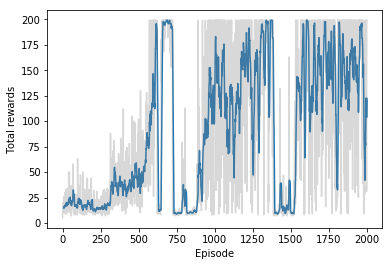

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

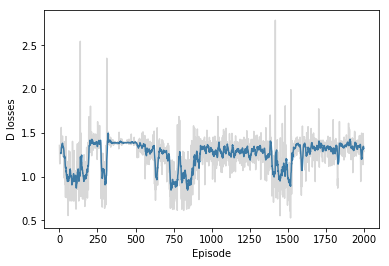

In [24]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

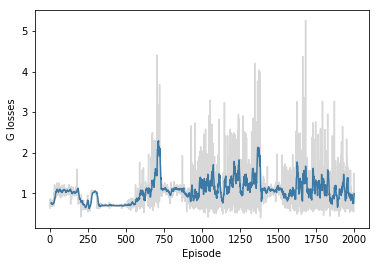

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

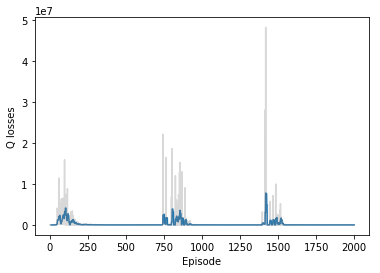

In [26]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [28]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.